# Environment setup

In [77]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Library preparation

In [78]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import time, os, io, clipboard
from PIL import ImageGrab
from IPython.display import Image, display
from scipy import stats
from si_prefix import si_format
from math import *
from tqdm import tqdm, tqdm_notebook

from io import StringIO 
import pandas as pd
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
plt.close('all')

from JJ_data_processing import *
from JJformulas import *

import sys 
sys.path.append('..')
from meas_util import *

import qcodes as qc
from qcodes import Station, load_by_run_spec, load_by_guid
from qcodes.instrument.base import Instrument
from qcodes.dataset.experiment_container import (Experiment,
                                                 load_last_experiment,
                                                 new_experiment, experiments)
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id, get_data_by_id, plot_dataset
from qcodes.dataset.data_set import load_by_id
# from qcodes.dataset.data_export import get_shaped_data_by_runidb

### Database ini

In [80]:
SAMPLE = '79N5'
qc.config["core"]["db_location"] = r'\\JOSH-PC\OurData_OneDrive\Experiments_{}.db'.format(SAMPLE)

## Scripts

### Data proc

In [81]:
def extract_Isw_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']

        
    return extract_Isw (Is,Vs)

def extract_Isw (Is,Vs):
    
        if len( Is )== 0 or len( Vs )== 0 :
            Isw, R0 = np.nan, np.nan
            return Isw, R0
        
        
        
        Isw = abs(np.max(Is)) 
        

        
        return Isw

In [107]:
def extract_Isw_R0 (Is,Vs):

    try:
        Isw = (np.max(Is) - np.min(Is) ) /2
    except ValueError:
        Isw = np.nan
    
#     Isw = (np.max(Is) - np.min(Is) ) /2

    order = Is.argsort()        
    Is, Vs = Is[order], Vs[order]
    n = len(Is)
    n_min, n_max = np.int(n/3), np.int(2*n/3)        
    n_sl = slice(n_min, n_max)

    R0 = np.mean(np.diff(Vs[n_sl])) / np.mean(np.diff(Is[n_sl]))        
    return Isw, R0

def extract_Isw_R0_by_id (idx):
    
    alldata = get_data_by_id(idx)
    
    Is = alldata[0][0]['data']
    Vs = alldata[0][1]['data']
        
    return extract_Isw_R0 (Is,Vs)

In [83]:
def xy_by_id(idx):
    alldata = get_data_by_id(idx)
    
    x = alldata[0][0]['data']
    y = alldata[0][1]['data']
    
    return x,y

In [84]:
def batch_plot_by_id(ids, ax = None, labels = None, **kw):
    if ax is None:
        fig, ax = plt.subplots()
        
    for i, idx in enumerate(ids):
        if labels is not None:
            label = labels[i]
        else:
            label = ''
            
        plot_by_id(idx, axes = ax, label = label, **kw)
        
    ax.legend()
    

In [85]:
def JJpar(RN, JJwidthUM=0.2, metalTHK=250E-10, Tc=1.34):
   
    Rs_JJ = RN * ( (JJwidthUM*1E-6 + 2*metalTHK) *JJwidthUM*1E-6 )
    IAB = const.pi *1.764 *const.k *Tc /2 /const.e /RN
    EJ_JJ = const.h /2 /const.e /2 /const.pi *IAB
    C_JJ = 50E-15 *JJwidthUM *JJwidthUM
    EC_JJ = const.e *const.e /2 /C_JJ
    C0 = ParplateCap(area= 56*1E-12 , dielecTHK=10E-9, epsilon = 9.34*const.epsilon_0)
    EC0 = const.e *const.e /2 /C0
   
    freqPlasma = sqrt(2 *const.e *IAB *2*const.pi /const.h /max(C0,C_JJ)) /2/const.pi
    Q = freqPlasma*2*pi *RN *max(C0,C_JJ)
    EJoEc = EJ_JJ/min(EC0,EC_JJ)

#     key =  [ 'RN_JJ',   'Rs_JJ', 'I_AB',   'EJ', 'C_JJQP',   'EC', 'C0', 'EC0', 'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
#     unit=  [   'ohm', 'ohm-m^2',    'A',    'J',      'F',    'J',  'F',   'J',          'Hz',  '',     '',      '']
#     lst = [[     RN ,    Rs_JJ ,   IAB , EJ_JJ ,    C_JJ , EC_JJ ,  C0 ,  EC0 ,    freqPlasma,  Q ,   Q*Q ,  EJoEc ]]
    key =  [ 'RN_JJ',    'Rs_JJ', 'I_AB',           'EJ',  'C_JJQP',          'EC',    'C0',       'EC0',  'Freq_plasma', 'Q', 'Beta', 'EJ/EC']
    unit=  [  'kohm','kohm*um^2',   'nA',            'K',      'fF',           'K',    'fF',         'K',          'GHz',  '',     '',      '']
    lst = [[ RN/1e3 , Rs_JJ*1e9 ,IAB*1e9, EJ_JJ/const.k , C_JJ*1e15, EC_JJ/const.k, C0*1e15, EC0/const.k, freqPlasma/1e9,  Q ,   Q*Q ,  EJoEc ]]
    JJparDFM =   pd.DataFrame(  data  = list(zip(*lst)),
                                index = key ).transpose()
    JJparUNI =   dict(zip(key, unit))

    return JJparDFM,JJparUNI

def ParplateCap(area, dielecTHK, epsilon = 9.34*const.epsilon_0):
    C = epsilon *area /dielecTHK
    return C

#### Exps

In [122]:
FF_ = .230e-3
ZF_ = -.00e-3

def populate_exps (exps,ZF_ = .004e-3, FF_ = .232e-3, VERBOSE = False):

    texps = tqdm_notebook(exps)
    for exp in texps:

        Isws = []
        R0s = []

        if VERBOSE:
            fig, ax = plt.subplots()

        Is = []
        Vs = []

        Irs = []
        Vrs = []

        Ils = []
        Vls = []

        for i in exp['ids']:

            I, V = xy_by_id(i)

            Tb = exp['T']

            ind_Vmax = np.argmax(I)
            ind_Vmin = np.argmin(I)

            ind_I0 = np.argmin(abs(I - 0e-12))
            ind_near0 = np.where(abs(I) > 0e-9)

            V_off = np.mean(V[ind_near0])
#             V -= V_off

            I, V = cut_dxdy(I, V, dx = 250e-9 ,dy = 30e-6)

            V_off = np.mean(V)
#             V -= V_off

    
            g0 = np.where(I>0)
            l0 = np.where(I<0)

            Ir, Vr = I[g0], V[g0]
            Il, Vl = I[l0], V[l0]


            if VERBOSE:
                ax.plot(I,V, 'o')

            Isw, R0 = extract_Isw_R0 (I,V)
            Isws.append(Isw)
            R0s.append(R0)


            Is.append(I)
            Vs.append(V)

            Irs.append(Ir)
            Vrs.append(Vr)

            Ils.append(Il)
            Vls.append(Vl)



        exp ['Is' ] =  Is
        exp ['Vs' ] =  Vs

        exp ['Irs' ] =  Irs
        exp ['Vrs' ] =  Vrs

        exp ['Ils' ] =  Ils
        exp ['Vls' ] =  Vls



        exp ['Isws'] =  np.array(Isws)
        exp ['R0s' ] =  np.array(R0s )
        exp ['cos' ] =  np.array( abs(np.cos(np.pi*(exp['B'] - ZF_ )/(2* (FF_ - ZF_)  )) ) )


#### Hist

In [87]:
def load_hist_by_id(idx):
    _, Isws = xy_by_id(idx)
    return Isws

In [88]:
def plot_hist_by_id(idx, ax = None, cumulative = False ):
    _, Isws = xy_by_id(idx)
    if ax is None:

        fig, ax = plt.subplots()

    ax.hist(Isws, bins = 201, cumulative = cumulative )
    return Isws

In [89]:
def save_hist(Isws, label = ''):     
    N_try = qc.Parameter('try')    

    meas = set_meas( Isrc.I, N_try, setup = setup, cleanup = cleanup)
    name = '{:} @T ={:2.1f}mK'.format(label, T8.get()/1e-3)
    name_exp(sample = SAMPLE, exp_type = name )  
    with meas.run() as datasaver: 
        for j, I in enumerate(Isws):
            res = [ ( N_try, j  ) ,( Isrc.I, I ),]

            datasaver.add_result(*res)
            
    print('Run # {:1.0f}, {:} saved'.format(datasaver.run_id, name))

In [90]:
def fit_hist_by_id(idx, EJ = 4, Ec = 0.05, dIdt = 30e-9, bins = 21):

    def wpK(EjK, EcK):
        return np.sqrt(8*EjK*EcK)
    
    eps = .001
    
    Isw = abs(load_hist_by_id(idx ))

    counts, Ibins = np.histogram(Isw, bins = bins)
    dI = np.mean( np.diff(Ibins) )

    SP = np.cumsum(counts)/len(Isw)
    Gamma = np.array([ np.log( (1 - SP[i])/(1 - SP[i+1]) ) for i in range(len(SP)-1)  ])*dIdt/dI


    Ic = 2*pi*EJ/Φ0*kB
    Ic0 = 1.5 * np.max(Isw)
    Ib = Ibins[:-2]
    
    while abs((Ic - Ic0)/Ic) > eps:
        Ic = Ic0
        wa = wpK(EJ, Ec)*kB/hbar/2/pi * (1 - (Ib/Ic)**2)**0.25

        coeff =  (-np.log(2*pi*Gamma/wa))**(2/3)
        i = np.isfinite(coeff) 
        
        a, b = np.polyfit( Ib[i], coeff[i],1)
        Ic0 = -b/a
        Teff = -1/kB*Φ0/2/pi*4*np.sqrt(2)/3 /np.sqrt(b)/a
    

    return Ic0, Teff

In [91]:
# def fit_plot_hist_by_id(idx, ax = None, EJ = 4, 
#                         Ec = 0.05,dIdt = 30e-9, bins = 21):

#     eps = .001
    
#     Isw = abs(load_hist_by_id( idx ))

#     counts, Ibins = np.histogram(Isw, bins = bins)
    
#     Ib = Ibins[:-2]
    
#     Ic0, Teff, coeff = fit_hist_by_id(idx, EJ = EJ, Ec = Ec,
#                                dIdt = dIdt, bins = bins)
#     print( Ic0, Teff )  

#     if ax is None:
#         fig, ax = plt.subplots()
#         add_legend = True
#     else:
#         add_legend = False
#     l = ax.plot(Ib, coeff, 'x')
#     c = l[0].get_color()
    
#     Iplot = np.linspace(np.min(Ib), Ic0, 101)
#     ax.plot(Ib, a*Ib + b, c = c, ls = '--', 
#             label = 'Tesc = {:1.0f} mK, Ico = {:1.0f} nA'. format(Teff/1e-3, Ic0*1e9))
#     if add_legend:
#         ax.legend()

#     return ax
    

## Measurement plan

- check subgap features
- record Isw statistics

#### Constants

In [92]:
ZF =  0.004e-3
FF =  0.224e-3
dF = 0.250e-3
midF = 0.154e-3

from scipy.constants import e, hbar,h, k, pi

Φ0 = h/2/e 
kB = k
Δ = 2.1*kB

#### Device info

In [93]:
devlst = {'D079N1': JJpar(RN=  290e3/.5, JJwidthUM=np.sqrt( .177 *  .177)),
          'D079N3': JJpar(RN=  520e3/ 8, JJwidthUM=np.sqrt( .784 *  .263)),
          'D079N5': JJpar(RN=   25e3/ 7.5, JJwidthUM=np.sqrt( 2.25 *  1.74)),
          'D079N6': JJpar(RN= 2.15e3/.5, JJwidthUM=np.sqrt( 2.21 *  1.72)),
          'D079N0': JJpar(RN= 24.3e3/ 8, JJwidthUM=np.sqrt( 2.21 *  1.67))}

a     = devlst['D079N1'][0]
unit  = devlst['D079N1'][1]
idlst = []
for dev in devlst:
    a = a.merge(devlst[dev][0], 'outer')
    idlst.append(dev)
   
a.insert(loc = 0, column = 'dev id', value = idlst)
a

,dev id,RN_JJ,Rs_JJ,I_AB,EJ,C_JJQP,EC,C0,EC0,Freq_plasma,Q,Beta,EJ/EC
0,D079N1,580.000000,23.303820,0.551656,0.013150,1.56645,0.593460,463.10944,0.002007,0.302792,511.017683,261139.072095,6.550834
1,D079N3,65.000000,14.878252,4.922465,0.117337,10.30960,0.090171,463.10944,0.002007,0.904486,171.071873,29265.585666,58.453599
2,D079N5,3.333333,13.379773,95.988068,2.288073,195.75000,0.004749,463.10944,0.002007,3.994101,38.740151,1500.799265,1139.845186
3,D079N6,4.300000,16.764338,74.409355,1.773700,190.06000,0.004891,463.10944,0.002007,3.516610,44.000353,1936.031052,883.600919
4,D079N0,3.037500,11.502271,105.336701,2.510917,184.53500,0.005038,463.10944,0.002007,4.184083,36.981121,1367.603330,1250.858914


# 12/19 KK WS

## Full IVc scan 

<IPython.core.display.Javascript object>


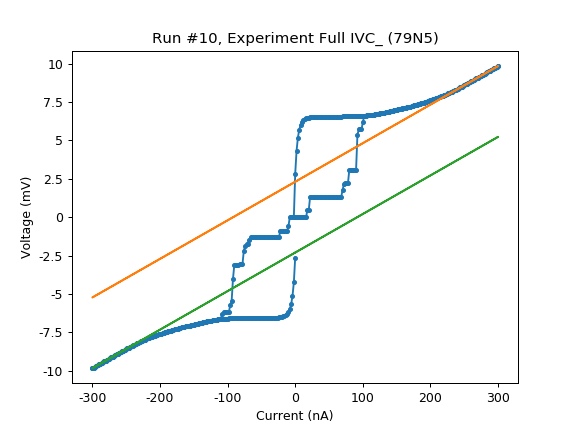

25145.78976923081 0.002307487856692293
25141.247346153872 -0.0023066672754615287


In [52]:
fig, ax = plt.subplots()

plot_by_id(10, axes = ax, marker = '.', ls = '-')

I, V = xy_by_id(10)

for cond in [ I > 250e-9 , I < -250e-9]:
    idx = np.where(cond)

    a,b = np.polyfit(I[idx], V[idx], 1)

    print(a,b)

    ax.plot(I, I*a + b)

R_chain = 25 kOhm
Vg = 6.5 mV / 436 = 15 SQUIDs
R_sq = 1.67 kOhm

Intercept = 2.3 mV/15 = 153 uV

More careful blow up (20 nA)


<IPython.core.display.Javascript object>


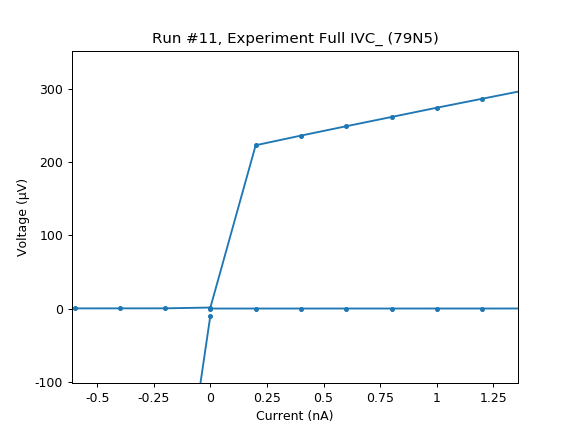

([<matplotlib.axes._subplots.AxesSubplot at 0x10172250>], [None])

In [132]:
plot_by_id(11, marker = '.', ls = '-')

## B period
    Meas sc branch (0 - 15 nA, below first jump) with fast 4 Vmeter 

<IPython.core.display.Javascript object>


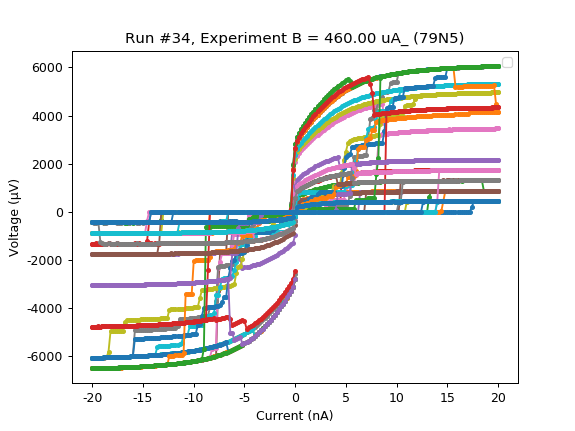

No handles with labels found to put in legend.


In [103]:
batch_plot_by_id(range(14, 34+1),  marker = '.', ls = '-')

<IPython.core.display.Javascript object>


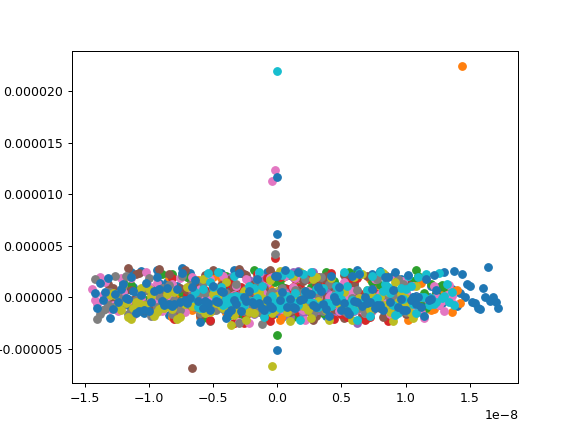

<IPython.core.display.Javascript object>


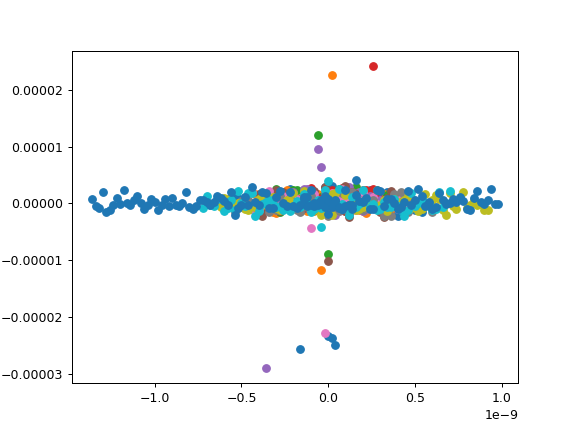

In [136]:
keys = [ 'ids', 'T',    'B',  'comments'        ] 

valss =[
      [range(14,34+1),45e-3, np.linspace(0, 460e-6, 21), 'IVc vs B'  ],
      [range(35,55+1),45e-3, np.linspace(160e-6, 280e-6, 21), 'IVc vs B'  ]]



exps = [{ key : val for key, val in zip(keys, vals)  }  for vals in valss ]


populate_exps (exps, VERBOSE = True, ZF_ = .00e-3, FF_ = .210e-3)

<IPython.core.display.Javascript object>


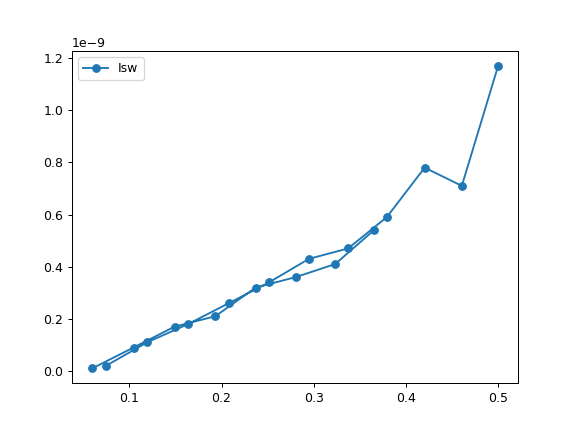

In [139]:
fig, ax = plt.subplots()

exp = exps[1]

ax.plot(exp ['cos' ] , exp['Isws'], 'o-', label = 'Isw')

ax.legend()

Blow up near FF

<IPython.core.display.Javascript object>


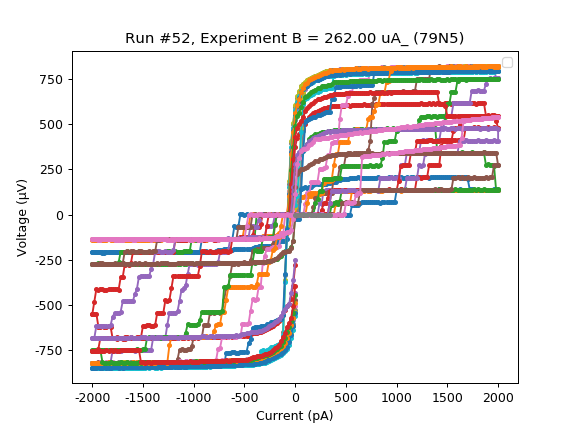

No handles with labels found to put in legend.


In [133]:
batch_plot_by_id(range(35, 52+1),  marker = '.', ls = '-')

Many steps!
ZF = 0 (?)
FF = 210 (for sure)

Where is a gap (15*437uV) for FF??

Meas full IVc for cos = .15 to see all the features?

<IPython.core.display.Javascript object>


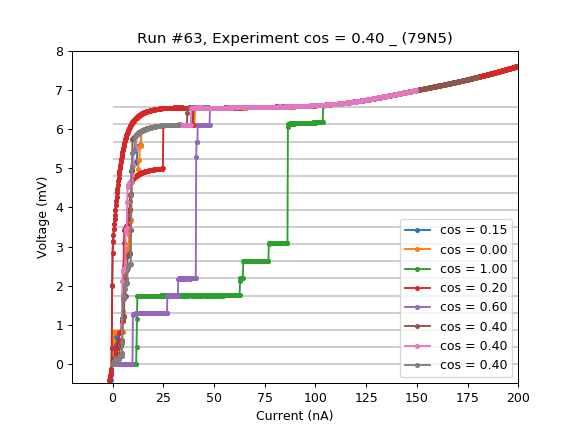

In [166]:
ls = [ 'cos = {:1.2f}'.format(c) for c in [.15, 0, 1, .2, .6, .4, .4, .4] ] 
# 'cos  = .15', 'cos  = 0', 'cos  = 1', 'cos  = .2', 'cos  = .6'

f,ax = plt.subplots()
batch_plot_by_id(range(56, 63+1), 
                 labels = ls,marker = '.', ls = '-', ax=ax)

ax.set_xlim(-20e-9,200e-9)
ax.set_ylim(-.5e-3,8e-3)

for i in range (16):
    ax.hlines(i*437e-6, 0,1, alpha = 0.2)

For the last jump, all curves seems to have similar Ic_last when cos <0.4. What does that mean? The last jump 

<IPython.core.display.Javascript object>


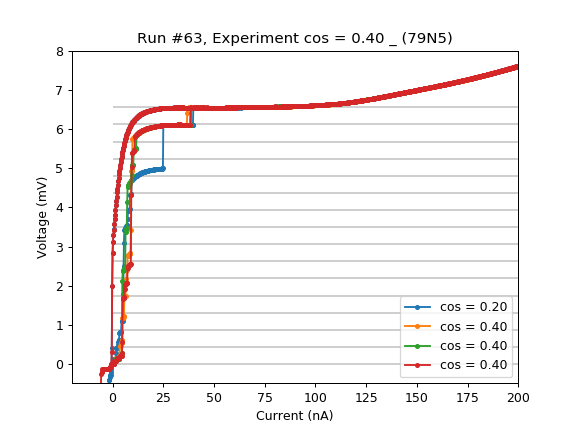

In [169]:
ls = [ 'cos = {:1.2f}'.format(c) for c in [.2, .4, .4, .4] ] 
# 'cos  = .15', 'cos  = 0', 'cos  = 1', 'cos  = .2', 'cos  = .6'

f,ax = plt.subplots()
batch_plot_by_id([59,61,62,63], 
                 labels = ls,marker = '.', ls = '-', ax=ax)

ax.set_xlim(-20e-9,200e-9)
ax.set_ylim(-.5e-3,8e-3)
c

cos = 0.4 is NOT stochastics, but its 2nd from the last jump occurs EARLIER than the one in cos = 0.2 does. Does this suggest that the different SQUID loop has different FF points?!

<IPython.core.display.Javascript object>


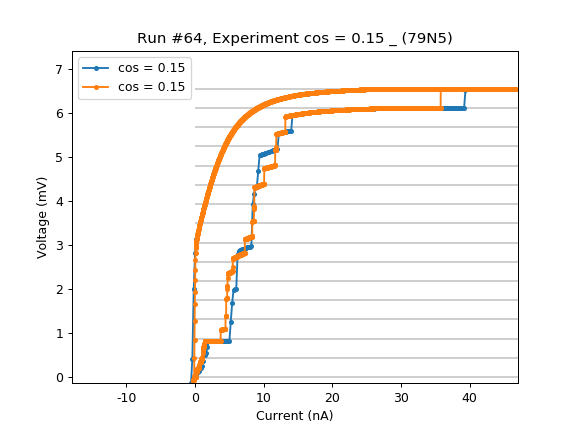

In [179]:
ls = [ 'cos = {:1.2f}'.format(c) for c in [.15, .15] ] 
# 'cos  = .15', 'cos  = 0', 'cos  = 1', 'cos  = .2', 'cos  = .6'

f,ax = plt.subplots()
batch_plot_by_id([56,64], 
                 labels = ls,marker = '.', ls = '-', ax=ax)

# ax.set_xlim (-5e-9,15e-9)
# ax.set_ylim (-1e-3,6e-3)
for i in range (16):
    ax.hlines(i*437e-6, 0,200e-9, alpha = 0.2)